데이터 출처 - https://data.mendeley.com/datasets/8gx2fvg2k6/5

In [ ]:
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5 
    !pip install pdpbox
    !pip install shap


In [2]:
# import libraries
import pandas as pd
from pandas_profiling import ProfileReport

from category_encoders import OneHotEncoder,OrdinalEncoder

from scipy import stats

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip -qq '/content/gdrive/MyDrive/data/archive.zip'

In [34]:
# read dataset

data = pd.read_csv('/content/DataCoSupplyChainDataset.csv',header= 0,encoding='unicode_escape')
data,rest_data = train_test_split(data,test_size=0.8)

In [ ]:

profile = ProfileReport(data, minimal=True).to_notebook_iframe()

In [ ]:
#data description

pd.read_csv('/content/DescriptionDataCoSupplyChain.csv')

In [35]:
#reset target
data['Late_delivery_risk'] = data['Days for shipping (real)'] - data['Days for shipment (scheduled)']

data["Late_delivery_risk"] = data["Late_delivery_risk"].apply(lambda x: 0 if x <= 0 else 1  )

data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1,inplace=True)


In [37]:
# EDA - check data types
def data_info(df):
  print("Shape", df.shape)
  print("'\n'Number of numeric_columns: ", len(numeric_col) ) 
  print("'\n'Number of category_columns: ", len(category_col) )

numeric_col =[i for i in data.columns if data.loc[:,i].dtypes != 'object']
category_col =[i for i in data.columns if data.loc[:,i].dtypes == 'object']

data_info(data)  

Shape (36103, 51)
'
'Number of numeric_columns:  27
'
'Number of category_columns:  24


In [8]:
# EDA  - check missing values
def print_missinvlaue(df):
  for i in  df.columns:
    m_v = df[i].isnull().sum()
    if m_v != 0:
      print(i, m_v)
  
print_missinvlaue(data)

Customer Lname 1
Customer Zipcode 1
Order Zipcode 31183
Product Description 36104


In [9]:
# EDA -  cardinality check
for i in category_col:
  print(i,len(data[i].unique()))
#data.describe(exclude='number').T.sort_values(by='unique')

Type 4
Delivery Status 4
Category Name 50
Customer City 562
Customer Country 2
Customer Email 1
Customer Fname 674
Customer Lname 1063
Customer Password 1
Customer Segment 3
Customer State 45
Customer Street 6678
Department Name 11
Market 5
Order City 3192
Order Country 156
order date (DateOrders) 28251
Order Region 23
Order State 1021
Order Status 9
Product Image 117
Product Name 117
shipping date (DateOrders) 27882
Shipping Mode 4


In [ ]:
# EDA - duplicatred value check 
data.duplicated().value_counts()

False    36104
dtype: int64

In [40]:
data.columns

Index(['Type', 'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product Description', 'Product Image', 'Product Name', 'Product Price',
      

In [39]:
# split data set

target = 'Late_delivery_risk'
features = data.columns.difference([target])

train,test = train_test_split(data, test_size=0.2 , random_state = 10)
train,val  = train_test_split(train, test_size=0.2 , random_state = 10)

X_train =train[features]
X_val =val[features]
X_test =test[features]

y_train = train[target]
y_val = val[target]
y_test= test[target]

In [ ]:
# EDA - statistics
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Benefit per order,23106.0,22.702985,105.634451,-3000.000000,7.440000,31.545000,65.500000,911.799988
Category Id,23106.0,31.792868,15.576797,2.000000,18.000000,29.000000,45.000000,76.000000
Customer Id,23106.0,6695.444949,4135.769433,2.000000,3315.000000,6476.000000,9777.000000,20749.000000
Customer Zipcode,23105.0,36215.234235,37475.743317,603.000000,725.000000,20019.000000,78223.000000,99205.000000
Department Id,23106.0,5.440232,1.627506,2.000000,4.000000,5.000000,7.000000,12.000000
Latitude,23106.0,29.872102,9.799862,-33.937553,18.266413,33.415199,39.318256,48.781933
Longitude,23106.0,-85.113475,21.315923,-158.025986,-98.466858,-77.007332,-66.370583,115.263077
Order Customer Id,23106.0,6695.444949,4135.769433,2.000000,3315.000000,6476.000000,9777.000000,20749.000000
Order Id,23106.0,36128.828270,20995.646175,4.000000,17937.000000,36122.000000,53841.250000,77196.000000
Order Item Cardprod Id,23106.0,691.702631,335.753174,19.000000,403.000000,627.000000,1004.000000,1363.000000


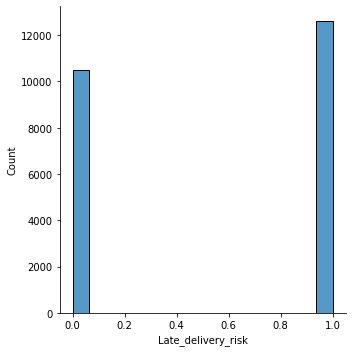

In [14]:
# EDA -target distribution
sns.displot(y_train)

In [16]:
y_train.value_counts(normalize=True)

1    0.545813
0    0.454187
Name: Late_delivery_risk, dtype: float64

In [ ]:
# EDA- remove high correlationship
def remove_high_corr(data)
  cor= data.corr()
  high_cor =[]
  for i in range(cor.shape[0]):
    for j in range(i+1, cor.shape[0]):
        if cor.iloc[i,j] > 0.8:
          high_cor.append(cor.columns[j]) 
     
# remove_high_corr(X_train)
# remove_high_corr(X_val)
# remove_high_corr(X_test)
# data.drop(set(high_cor),axis=1, inplace=True)


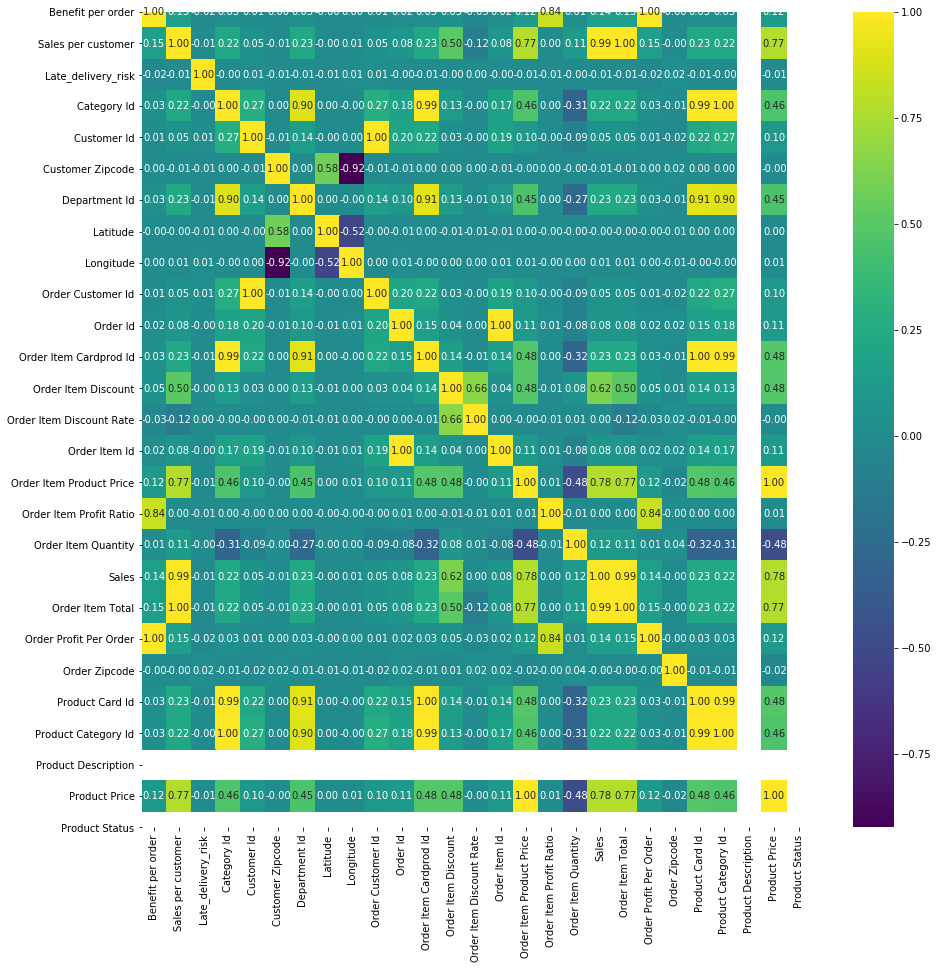

In [ ]:
corr = train.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt="0.2f", cmap='viridis')
plt.show()

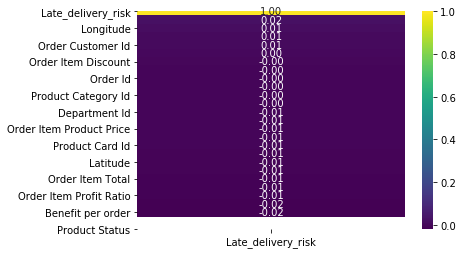

In [ ]:
# EDA- visualize correlation coefficient numeric data 
corr_target = round(train.corr()['Late_delivery_risk'].sort_values(ascending=False),5)
corr_target = pd.DataFrame(corr_target)

sns.heatmap(corr_target, annot=True, fmt="0.2f", cmap='viridis')
plt.show()

In [41]:
train.columns

Index(['Type', 'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product Description', 'Product Image', 'Product Name', 'Product Price',
      

In [42]:
def preprocessing_drop_feature(df):

    # drop unwanted  columns , high correationship  ,leakege data 
    drop_l = ["Benefit per order"  
               ,'Category Id'
               ,'Customer Email','Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Password'
               , 'Customer Street','Customer Zipcode','Customer Street','Customer City','Customer Country' 
               ,'Department Id','Delivery Status'
               ,'Order Customer Id','Order Id','Order Item Cardprod Id','Order Item Discount','Order Item Id'
               ,'Product Image','Product Category Id','Product Card Id'
               ,'order date (DateOrders)','Order Item Total','Order Profit Per Order','shipping date (DateOrders)'
                ,'Customer State']
    df.drop(drop_l,axis=1,inplace=True)

    
    # drop columns with many missing values
    drop_l = ['Product Description','Order Zipcode']
    df.drop(drop_l,axis=1,inplace=True)


    # Delete rows with missing values
    df.dropna(inplace=True)


    return df

X_train = preprocessing_drop_feature(X_train)
X_val = preprocessing_drop_feature(X_val)
X_test = preprocessing_drop_feature(X_test)
train = preprocessing_drop_feature(train)


In [43]:
# feature engineering
def feature_engineering(df):
  
  df['Order Area'] = df['Order Country']+' '+df['Order State']+' '+df['Order City'] 
  df.drop(['Order Country','Order State','Order City'], axis=1 ,inplace=True)

  df['Department_Categoty_Name'] = df['Department Name']+' '+df['Category Name']
  df.drop(['Department Name','Category Name'], axis=1 ,inplace=True)

  
  enc =  OrdinalEncoder( {None:0, 'Standard Class':1, 'Second Class':0,'First Class ':2, 'Same Day':3 } )
  enc =  enc.fit(df['Shipping Mode'])
  df['Shipping Mode'] = enc.transform(df['Shipping Mode'])

  return df

X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)
train = feature_engineering(train)

In [ ]:
# Distribution plot about all features 
plt.figure(figsize=(24,50))

try:
  for i,col in enumerate(data.columns):
    plt.subplot(5,5,i+1)
    plt.hist(data[col], label=col)
    plt.legend()
    plt.title(col)
    plt.tight_layout()
except Exception as e:
    print(col,e)

In [ ]:
# EDA - one way anova
for i in train.columns:
  F_df = train.loc[:,['Late_delivery_risk',i]]
  oh_encoder = OneHotEncoder(use_cat_names=True)
  F_df =oh_encoder.fit_transform(F_df)
  for j in range(len(F_df.columns)):
    statistic, pvalue = stats.f_oneway(F_df.iloc[:,0] ,F_df.iloc[:,j])
    if pvalue <0.05:
      print(F_df.columns[1])
      break

Type_PAYMENT
Sales per customer
Customer Segment_Corporate
Latitude
Longitude
Market_USCA
Order Item Discount Rate
Order Item Product Price
Order Item Profit Ratio
Order Item Quantity
Sales
Order Region_US Center 
Order Status_PENDING_PAYMENT
Product Name_Nike Men's Dri-FIT Victory Golf Polo
Product Price
Product Status
Shipping Mode
Order Area_Estados Unidos Michigan Jackson
Department_Categoty_Name_Golf Women's Apparel


In [ ]:
numeric_col =[i for i in X_train.columns if X_train.loc[:,i].dtypes != 'object']
category_col =[i for i in X_train.columns if X_train.loc[:,i].dtypes == 'object']


In [22]:
# Skew 
left_skew = []
right_skew = []
skew = X_train.skew()
for i,v in enumerate(skew):
  if v > 3:
    right_skew.append(skew.index[i])
  elif v <-3:
    left_skew.append(skew.index[i])



In [23]:
import numpy as np
X_train[left_skew] = np.log(X_train[left_skew])
X_train[right_skew] = np.log(X_train[right_skew])

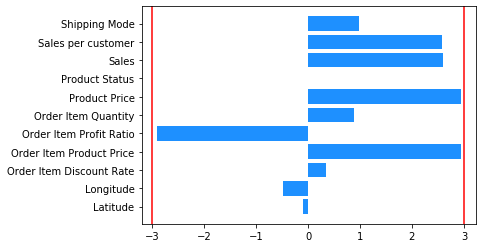

In [ ]:
# Skewed graph
plt.barh(X_train.skew().index,X_train.skew().T, color='dodgerblue')
plt.axvline(x=-3,ymin=0, ymax=1,color='r')
plt.axvline(x=3,ymin=0, ymax=1,color='r')
plt.show()


In [44]:
# model fit  -random froest
pipe_rf = make_pipeline(
    OrdinalEncoder()
    ,RandomForestClassifier(random_state=10)
)
pipe_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Customer Segment', 'Market',
                                      'Order Region', 'Order Status',
                                      'Product Name', 'Type', 'Order Area',
                                      'Department_Categoty_Name'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Customer Segment',
                                          'data_type': dtype('O'),
                                          'mapping': Corporate      1
Consumer       2
Home Office    3
NaN...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=N

In [45]:
# result 
from sklearn.metrics import classification_report

print(classification_report(y_test, pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.76      0.68      3137
           1       0.78      0.64      0.70      4084

    accuracy                           0.69      7221
   macro avg       0.70      0.70      0.69      7221
weighted avg       0.71      0.69      0.69      7221



In [46]:

print(classification_report(y_val, pipe_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.54      0.74      0.63      2466
           1       0.73      0.54      0.62      3311

    accuracy                           0.63      5777
   macro avg       0.64      0.64      0.63      5777
weighted avg       0.65      0.63      0.62      5777



In [ ]:
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV

pipe_gr = make_pipeline(
    TargetEncoder(),
    XGBClassifier(random_state=10)
)

param_grid  = {     
    'xgbclassifier__n_estimators': [500,700], 
    'xgbclassifier__max_depth': [8,10,15], 
    'xgbclassifier__learning_rate' : [0.01, 0.1],
}

grid=GridSearchCV(
    pipe_gr,
    param_grid=param_grid ,   
    scoring='recall' ,
)
grid.fit(X_train, y_train) 
grid.best_params_

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 15,
 'xgbclassifier__n_estimators': 700}

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 15,
 'xgbclassifier__n_estimators': 700}

In [ ]:
model=grid.best_params_

In [66]:
from category_encoders import TargetEncoder
pipe_xg= make_pipeline(
    TargetEncoder(),
    XGBClassifier(learning_rate =0.1,
    max_depth=5,
    n_estimators = 1000,
    random_state=10)
)
pipe_xg.fit(X_train,y_train) 

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['Customer Segment', 'Market',
                                     'Order Region', 'Order Status',
                                     'Product Name', 'Type', 'Order Area',
                                     'Department_Categoty_Name'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=...ster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=1000, n_jobs=1, nthread=

  
  'xgbclassifier__n_estimators': [100,200,300,500], 
   'xgbclassifier__max_depth': [2,4,8,10], 
  'xgbclassifier__learning_rate' : [0.01, 0.1],

  xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 8,
 'xgbclassifier__n_estimators': 300}

In [67]:
print(classification_report(y_test, pipe_xg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67      3137
           1       0.75      0.69      0.72      4084

    accuracy                           0.70      7221
   macro avg       0.69      0.70      0.69      7221
weighted avg       0.70      0.70      0.70      7221



In [68]:
print(classification_report(y_val, pipe_xg.predict(X_val)))

              precision    recall  f1-score   support

           0       0.52      0.66      0.58      2466
           1       0.69      0.55      0.61      3311

    accuracy                           0.60      5777
   macro avg       0.60      0.61      0.60      5777
weighted avg       0.62      0.60      0.60      5777



Text(0.5, 1.0, 'Confusion matrix, n = 5777')

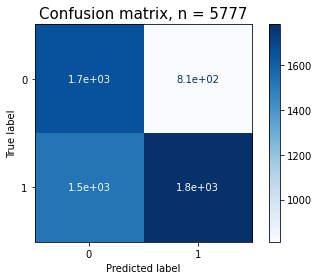

In [59]:
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline 
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_xg, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

Text(0.5, 1.0, 'Confusion matrix, n = 5777')

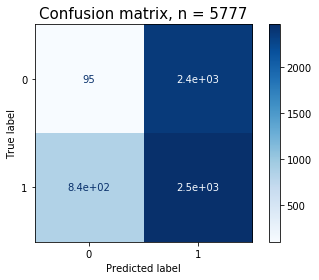

In [ ]:
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline 
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_rf, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

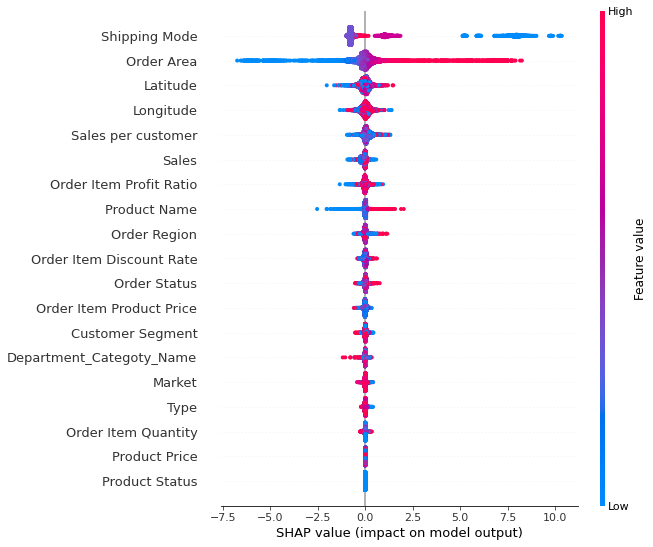

In [72]:
import shap

explainer = shap.TreeExplainer(pipe_xg.named_steps['xgbclassifier'])


# shap_values = explainer.shap_values(X_test.iloc[:100])
# shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:100])
shap_values = explainer.shap_values(pipe_xg.named_steps['targetencoder'].transform(X_test))
shap.summary_plot(shap_values, pipe_xg.named_steps['targetencoder'].transform(X_test))